# 파이토치 MNIST 모델

## modules import 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

## 전처리 설정
- `transform.Compose`

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])


## 데이터 로드 및 데이터 확인

In [3]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

In [16]:
image, label = next(iter(train_loader))

In [17]:
image.shape, label.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [18]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

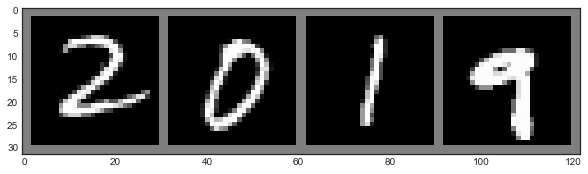

In [19]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:4]))

## 신경망 구성

In [5]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)           # 6*6 의 의미? 아니고 5*5로 해야 됨 왜??? : 28*28에서 3*3 conv. 2번, 2*2 maxpool 2번 하고나면 5*5 됨
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        # print("x__size :", x.size())                  # batch size 가 첫번째 element인지 확인
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]                             # 왜 size()[0]은 제외함? batch size가 들어가는 자리라서.
        num_features = 1
        for s in size:
            num_features *= s

        return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


- `.parameters()` 

In [67]:
params = list(net.parameters())
print(len(params))
print(params[9].size())

10
torch.Size([10])


임의의 값을 넣어 forward값 확인

In [22]:
input = torch.randn(128, 1, 28, 28)
out = net(input)
print(out)

tensor([[ 0.0771, -0.0309, -0.0589,  ...,  0.0092,  0.0624, -0.0139],
        [ 0.0779, -0.0027, -0.0450,  ..., -0.0049,  0.0294, -0.0321],
        [ 0.0772, -0.0281, -0.0652,  ..., -0.0040,  0.0573, -0.0068],
        ...,
        [ 0.0821, -0.0257, -0.0615,  ..., -0.0228,  0.0175, -0.0307],
        [ 0.0838, -0.0133, -0.0620,  ..., -0.0031,  0.0421, -0.0212],
        [ 0.0851, -0.0298, -0.0617,  ..., -0.0001,  0.0800, -0.0203]],
       grad_fn=<AddmmBackward0>)


## 손실함수와 옵티마이저

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 모델 학습

- `optimizer.zero_grad` : 가중치의 그래디언트 초기화

- loss 계산

- `loss.backward()`

- `optmizer.step()` : 업데이트

- 배치수 확인

In [24]:
total_batch = len(train_loader)
print(total_batch)                  # 위에서 train_loader 정의할 때 batch_size 128로 정했는데 왜 469..? 128은 미니배치 사이즈, 469는 mini-batch의 갯수

469


- 설명을 위해 `epochs=2`로 지정

In [7]:
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):     # 0은 시작 인덱스를 말함. i=0부터 시작함.
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if i % 100 == 99:
            print("Epoch: {}, Iter: {}, Loss: {}".format(epoch+1, i+1, running_loss/100))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 2.2984282636642455
Epoch: 1, Iter: 200, Loss: 2.2868125081062316
Epoch: 1, Iter: 300, Loss: 2.269633240699768
Epoch: 1, Iter: 400, Loss: 2.240709309577942
Epoch: 2, Iter: 100, Loss: 2.043582409620285
Epoch: 2, Iter: 200, Loss: 1.6418590366840362
Epoch: 2, Iter: 300, Loss: 1.060251429080963
Epoch: 2, Iter: 400, Loss: 0.6931831294298172


## 모델의 저장 및 로드

- `torch.save`
  - `net.state_dict()`를 저장

- `torch.load`
  - `load_state_dict`로 모델을 로드

In [26]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

In [27]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [28]:
net.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

## 모델 테스트

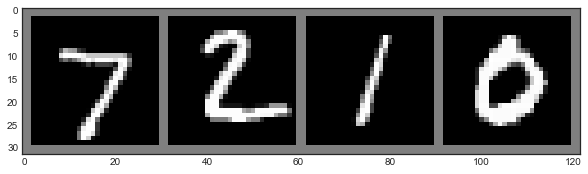

In [29]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

In [30]:
outputs = net(images)
outputs.size()
outputs
outputs.data

tensor([[-0.7829, -1.7729, -2.1527,  ...,  5.9306,  2.0675,  2.8639],
        [ 2.1832,  2.1652,  5.5881,  ..., -7.3187,  1.2926, -6.6575],
        [-1.4268,  3.0665,  0.4106,  ..., -1.2242,  0.7481, -1.0968],
        ...,
        [-2.1879,  0.0508, -0.0104,  ..., -0.3250,  1.0560,  2.3658],
        [ 6.3780, -3.6458,  4.6007,  ..., -4.6764,  1.2036, -5.4626],
        [ 0.0129, -2.5285, -2.9104,  ...,  2.7841,  2.7325,  2.3115]])

In [31]:
_, predicted = torch.max(outputs, 1)  # 동일 1순위 값이 있을 때 앞에 있는 index를 출력
print(predicted)

tensor([7, 2, 1, 0, 4, 1, 9, 9, 0, 9, 0, 6, 9, 0, 1, 3, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 3, 6,
        4, 4, 6, 3, 5, 3, 6, 0, 4, 1, 9, 7, 7, 8, 9, 3, 9, 4, 0, 4, 3, 0, 7, 0,
        2, 8, 1, 7, 3, 7, 9, 7, 7, 6, 2, 7, 9, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 9, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 9, 9, 4, 4, 9, 8,
        5, 4, 7, 6, 9, 4, 0, 5])


In [32]:
print(''.join('{}\t'.format(str(predicted[j].numpy())) for j in range(4)))

7	2	1	0	


In [8]:
# accuracy 계산

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)   # batch size 더함
        correct += (predicted == labels).sum().item()

print(100 * correct / total) 

83.48


## GPU 설정 후 학습
- 설정 후, 모델과 데이터에 `to`로 GPU를 사용 가능한 형태로 변환 해줘야 한다.

- `.cuda()` 로도 가능

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

- 현재 GPU 설정

In [35]:
torch.cuda.is_available()

True

In [36]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [37]:
device

device(type='cuda')

- 데이터 로드


In [52]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

- 모델 생성

In [53]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s

        return num_features

net = Net()
print(net)


Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [54]:
net = Net().to(device)

In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [57]:
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) # GPU 상에서 돌릴 때는 data를 GPU로 보내줘야함

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print("Epoch: {}, Iter: {}, Loss: {}".format(epoch+1, i+1, running_loss/100))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.5636289289593697
Epoch: 1, Iter: 200, Loss: 0.46902904868125916
Epoch: 1, Iter: 300, Loss: 0.4109480382502079
Epoch: 1, Iter: 400, Loss: 0.3939298060536385
Epoch: 2, Iter: 100, Loss: 0.3268948245048523
Epoch: 2, Iter: 200, Loss: 0.307376526594162
Epoch: 2, Iter: 300, Loss: 0.2791161112487316
Epoch: 2, Iter: 400, Loss: 0.2795764730870724


In [58]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(100 * correct / total)

92.62
